# Introduction

<h4> Dataset Description</h4>

The dataset used in this project contains tri-axial accelerometer readings recorded from a smartphone during different activities (`Standing = 1, Walking = 2, Stairs Down = 3, Stairs Up = 4`). Each reading includes:
- **X, Y, and Z coordinates**: Representing the acceleration in each of the three dimensions.
- **Timestamp and UTC time**: Representing the time of reccording.

The goal of this project is to classify these accelerometer readings into various activities based on the patterns observed in the data. The challenge lies in handling the class imbalance and extracting meaningful features from the raw accelerometer data to build an effective classification model.

<h4>Project Objectives and Key Steps</h4>

The primary objective is to develop a machine learning model capable of accurately predicting the activity label from accelerometer data. To achieve this, the project involves the following key steps:
1. **Data Preprocessing**: Cleaning and organizing the data to ensure quality and consistency.
2. **Feature Extraction**: Using techniques like Fourier Transform to derive features that capture the underlying patterns in the data.
3. **Model Training and Evaluation**: Selecting appropriate machine learning algorithms, tuning their hyperparameters, and evaluating their performance using relevant metrics such as accuracy, precision, recall, and F1 score. In addition, the imbalance in activity classes also needs to be addressed, to ensure the model performs well across all categories.
4. **Aplying the Model**: Applying the model to the test data and update the it with the outputed labels.

---

# Methods

<h4>Data Preprocessing</h4>

- Checked data for missing or corrupted values in the dataset.
- Checked class balance.
- Checked for incomplete sets of measurements.
- Enriched data with acceleration magnitude, `m`.
- Addressed `type` inconsistencies in the timestamp records.

<h4>Feature Extraction</h4>

- Applied the **Fourier Transform** to the accelerometer data to convert time-domain signals into frequency-domain features.
- Applied **Power Spectral Density (PSD)** analysis using the **Welch's method** to estimate power distribution across frequencies for each axis.
- Calculated autocorrelation for each X, Y, Z axes tp accpunt for signal periodicity.
- Extracted first `N` peaks from the PSD, FFT, and autocorrelation data as part of the feature set.
- Calculated statistical features for each axis: mean, standard deviation, minimum, maximum, median, and skewness.
- Added maximum differences between axes (X-Y, X-Z, Y-Z) to capture dynamic relationships between the directions.
- Derived angles between the magnitude (`m`) vector and the X, Y, Z axes for each window, averaged across window size to summarize orientation dynamics.

<h4>Modeling Approach</h4>

0. **Model Selection**:
   - Evaluated multiple traditional machine learning models including Random Forest, Decision Tree, K-Nearest Neighbors, Logistic Regression, and Support Vector Machine.
   - Used, primarily, a combination of precision, recall, and F1 score to select the best model.
   - Chose Random Forest model based on its far superior performance metrics, compared with the other models, despite being one of the less consistent accros folds.

1. **Class Imbalance Handling**:
   - Calculated **class weights** to account for imbalanced activity classes, which were applied during model training and selection to prevent bias towards the majority class.
   - Used **SMOTE (Synthetic Minority Over-sampling Technique)** to oversample minority classes.
   - Used **Stratified K-Fold** in cross-validation to maintain the class distribution across training and validation splits.

2. **Hyperparameter Tuning**:
   - Employed **Grid Search** with **Cross-validation** to find the optimal hyperparameters for the selected model.

3. **Pipeline and Evaluation**:
   - Implemented a pipeline to standardize the data and performed **PCA** for dimensionality reduction and potential ovefitting mitigation.
   - Evaluated the model using **Cross-validation** to assess performance on the test set refitting on the **F1 score** as the primary metric.

---

## Preamble

* Imports needed libraries and functions.
* Starts the timer to track the notebook's total runing time.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [57]:
from collections import Counter
from scipy.fft import fft
from scipy.signal import welch
from scipy.stats import skew
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler, label_binarize
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

In [58]:
# Starting the timer to track total notebook's runtime.
start_time = time.time()

## Data Preprocessing

* Load tri-axial accelerometer train and test files.
* Check loaded datasets for data quality and potential issues.

### Loading data

Importing data from `.csv` files stored locally in the project folder.

In [59]:
train_data = pd.read_csv('Input datasets/train_time_series.csv')
train_labels = pd.read_csv('Input datasets/train_labels.csv')

test_data = pd.read_csv('Input datasets/test_time_series.csv')
test_labels = pd.read_csv('Input datasets/test_labels.csv')

Previewing datasets.

In [60]:
train_data.head(2)

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554


In [61]:
train_labels.head(2)

,Unnamed: 0,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1


In [62]:
test_data.head(2)

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
1,24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975


In [63]:
test_labels.head(2)

,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,NaN
1,24349,1565110308043,2019-08-06T16:51:48.043,NaN


Preview datasets' shape.

In [64]:
shapes = f'Train data\'s shape: {train_data.shape}\nTrain label\'s shape: {train_labels.shape}\nTest data\'s shape: {test_data.shape}\nTest label\'s shape: {test_labels.shape}'
print(shapes)

Train data's shape: (3744, 7)
Train label's shape: (375, 4)
Test data's shape: (1250, 7)
Test label's shape: (125, 4)


### Data checks

Checking for any null values.

In [65]:
def check_nulls(df):
    null_rows = df.isnull().any(axis=1)
    return df[null_rows]

check_nulls(train_data), check_nulls(train_labels), check_nulls(test_data)

(Empty DataFrame
 Columns: [Unnamed: 0, timestamp, UTC time, accuracy, x, y, z]
 Index: [],
 Empty DataFrame
 Columns: [Unnamed: 0, timestamp, UTC time, label]
 Index: [],
 Empty DataFrame
 Columns: [Unnamed: 0, timestamp, UTC time, accuracy, x, y, z]
 Index: [])

Check for label balance.

In [66]:
pd.DataFrame.from_dict(Counter(train_labels['label']), orient='index', columns=['count'])

,count
1,27
2,213
4,47
3,88


### Data preparation

There were 4 extra samples in the end of the training dataset which did not encompassed a full 10 sample measurement. Analogously, the train labels contained one "extra" label, matching those 4 measurements.

As such a cleaning is performed on this "incomplete" data from the train datasets.

In [67]:
train_data = train_data[:-4]
train_labels = train_labels[:-1]

train_data.shape, train_labels.shape

((3740, 7), (374, 4))

Calculating the magnitude of each acceleration vector.

In [68]:
def magnitude(df):
    return np.sqrt(df.x**2 + df.y**2 + df.z**2)

train_data['m'] = magnitude(train_data)
test_data['m'] = magnitude(test_data)

Checking on timestamp columns' data type.

In [69]:
print('Origital datatype of UTC time:', type(train_data['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(train_labels['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(test_data['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(test_labels['UTC time'].iloc[1]))

Origital datatype of UTC time: <class 'str'>
Origital datatype of UTC time: <class 'str'>
Origital datatype of UTC time: <class 'str'>
Origital datatype of UTC time: <class 'str'>


Convert timestap data to time type.

In [70]:
train_data['UTC time'] =  pd.to_datetime(train_data['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
train_labels['UTC time'] =  pd.to_datetime(train_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
test_data['UTC time'] =  pd.to_datetime(test_data['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
test_labels['UTC time'] =  pd.to_datetime(test_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')

print('Origital datatype of UTC time:', type(train_data['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(train_labels['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(test_data['UTC time'].iloc[1]))
print('Origital datatype of UTC time:', type(test_labels['UTC time'].iloc[1]))

Origital datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Origital datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Origital datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Origital datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Feature Extraction

* Extract relevant features from the raw accelerometer data.

Given the periodic and repetitive nature of the motion data, analyzing the frequency domain provides valuable insights that might not be as clear in the time domain. To capture these patterns effectively, features are extracted using the Fourier Transform and Power Spectral Density (PSD) to represent frequency behavior, along with autocorrelation to capture periodicity in the time domain. These techniques are applied within time windows to summarize both frequency and time-domain behavior.

In [71]:
# PSD calculation using Welch's method
def calculate_psd(window_data, fs, window_size):
    """
    Compute the Power Spectral Density (PSD) using Welch's method.
    Returns the frequencies and PSD values for each axis.
    """
    # Set nperseg to window_size to match the number of data points in the window
    freqs, psd_x = welch(window_data['x'], fs=fs, nperseg=window_size)
    _, psd_y = welch(window_data['y'], fs=fs, nperseg=window_size)
    _, psd_z = welch(window_data['z'], fs=fs, nperseg=window_size)
    _, psd_m = welch(window_data['m'], fs=fs, nperseg=window_size)
    
    return freqs, psd_x, psd_y, psd_z, psd_m


# Feature extraction combining PSD, FFT, and Autocorrelation
def extract_features(data, window_size=10, sampling_rate=10, num_peaks=3):
    features = []

    for i in range(0, len(data) - window_size + 1, window_size):
        window_data = data.iloc[i:i + window_size]

        # Ensure the window size is valid
        if len(window_data) < window_size:
            continue

        # Calculate PSD
        _, psd_x, psd_y, psd_z, psd_m = calculate_psd(window_data, sampling_rate, window_size)

        # FFT with ascontiguousarray
        fft_x = np.abs(fft(np.ascontiguousarray(window_data['x'].to_numpy())))[:window_size // 2]
        fft_y = np.abs(fft(np.ascontiguousarray(window_data['y'].to_numpy())))[:window_size // 2]
        fft_z = np.abs(fft(np.ascontiguousarray(window_data['z'].to_numpy())))[:window_size // 2]
        fft_m = np.abs(fft(np.ascontiguousarray(window_data['m'].to_numpy())))[:window_size // 2]

        # Autocorrelation
        autocorr_x = np.correlate(window_data['x'], window_data['x'], mode='full')[window_size-1:][:num_peaks]
        autocorr_y = np.correlate(window_data['y'], window_data['y'], mode='full')[window_size-1:][:num_peaks]
        autocorr_z = np.correlate(window_data['z'], window_data['z'], mode='full')[window_size-1:][:num_peaks]
        autocorr_m = np.correlate(window_data['m'], window_data['m'], mode='full')[window_size-1:][:num_peaks]

        # Prepare the feature vector
        feature_vector = [window_data['UTC time'].median()]

        # PSD Features
        feature_vector.extend(psd_x[:num_peaks])
        feature_vector.extend(psd_y[:num_peaks])
        feature_vector.extend(psd_z[:num_peaks])
        feature_vector.extend(psd_m[:num_peaks])

        # FFT Features
        feature_vector.extend(fft_x[:num_peaks])
        feature_vector.extend(fft_y[:num_peaks])
        feature_vector.extend(fft_z[:num_peaks])
        feature_vector.extend(fft_m[:num_peaks])

        # Autocorrelation Features
        feature_vector.extend(autocorr_x[:num_peaks])
        feature_vector.extend(autocorr_y[:num_peaks])
        feature_vector.extend(autocorr_z[:num_peaks])
        feature_vector.extend(autocorr_m[:num_peaks])

        # Statistical Features (mean, std, min, max, median, skewness)
        for axis in ['x', 'y', 'z', 'm']:
            axis_data = window_data[axis]
            mean_val = np.mean(axis_data)
            std_val = np.std(axis_data)
            min_val = np.min(axis_data)
            max_val = np.max(axis_data)
            median_val = np.median(axis_data)
            skewness_val = skew(axis_data)

            # Add these stats to the feature vector
            feature_vector.extend([mean_val, std_val, min_val, max_val, median_val, skewness_val])

        # Max difference between axes for the entire window
        max_diff_xy = np.max(np.abs(window_data['x'] - window_data['y']))  # max difference between x and y
        max_diff_xz = np.max(np.abs(window_data['x'] - window_data['z']))  # max difference between x and z
        max_diff_yz = np.max(np.abs(window_data['y'] - window_data['z']))  # max difference between y and z

        # Add the three max differences to the feature vector
        feature_vector.extend([max_diff_xy, max_diff_xz, max_diff_yz])

        # Angles of the magnitude vector (m) with respect to x, y, and z axes (based on averaged values)
        avg_x = window_data['x'].mean()
        avg_y = window_data['y'].mean()
        avg_z = window_data['z'].mean()
        avg_m = window_data['m'].mean()  # The magnitude is already precomputed as column 'm'

        # Avoid division by zero when magnitude is zero
        if avg_m != 0:
            angle_x = np.arccos(avg_x / avg_m)  # Angle relative to x-axis
            angle_y = np.arccos(avg_y / avg_m)  # Angle relative to y-axis
            angle_z = np.arccos(avg_z / avg_m)  # Angle relative to z-axis
        else:
            angle_x = angle_y = angle_z = 0  # Set to 0 when magnitude is zero

        # Add these angles (one set per window) to the feature vector
        feature_vector.extend([angle_x, angle_y, angle_z])

        features.append(feature_vector)

    # Create DataFrame with features
    feature_columns = ['UTC time'] + \
                      [f'{axis}_{feature_type}_{i + 1}' for feature_type in ['psd', 'fft', 'autocorr']
                       for axis in ['x', 'y', 'z', 'm'] for i in range(num_peaks)] + \
                      [f'{axis}_{stat}' for axis in ['x', 'y', 'z', 'm'] for stat in ['mean', 'std', 'min', 'max', 'median', 'skew']] + \
                      ['max_diff_xy', 'max_diff_xz', 'max_diff_yz'] + \
                      ['angle_x', 'angle_y', 'angle_z']

    feature_df = pd.DataFrame(features, columns=feature_columns)

    return feature_df

Calculating sample frequency of each window for better accuracy when applying Fourier transforms.

In [72]:
# Calculate the mean time difference between consecutive 'UTC time' entries in the train_data DataFrame.
# This is essentially computing the average time interval between each sample in the training data.
T_train_data = np.mean([
    train_data['UTC time'].iloc[i+1] - train_data['UTC time'].iloc[i]  # Difference between consecutive 'UTC time' values
    for i in range(len(train_data['UTC time']) - 1)  # Iterate over the range up to the second-to-last index
])

# Calculate the overall sampling frequency (rate) of the training data.
# This is computed as the total number of samples divided by the total time span of the dataset in seconds.
f_train_data = len(train_data['UTC time']) / (  # Total number of samples
    train_data['UTC time'].iloc[-1] - train_data['UTC time'].iloc[0]  # Total duration between the first and last 'UTC time'
).total_seconds()  # Convert the total duration from a timedelta object to seconds

# Repeating the process for test data.
T_test_data = np.mean([test_data['UTC time'].iloc[i+1]-test_data['UTC time'].iloc[i] for i in range(len(test_data['UTC time'])-1)])
f_test_data = len(test_data['UTC time'])/(test_data['UTC time'].iloc[-1]-test_data['UTC time'].iloc[0]).total_seconds()

print('Train data: \nAverage time per sample - {:.2f} seconds\nFrequency per sample - {:.2f} Hz'.\
      format(T_train_data.total_seconds(), f_train_data))

print('\nTest data: \nAverage time per sample - {:.2f} seconds\nFrequency per sample - {:.2f} Hz'.\
      format(T_test_data.total_seconds(), f_test_data))

Train data: 
Average time per sample - 0.10 seconds
Frequency per sample - 9.98 Hz

Test data: 
Average time per sample - 0.10 seconds
Frequency per sample - 9.98 Hz


Extracting features for train and test data.

In [73]:
train_features = extract_features(train_data, window_size=10, sampling_rate=f_train_data, num_peaks=3)
test_features = extract_features(test_data, window_size=10, sampling_rate=f_test_data, num_peaks=3)

Checking datasets.

In [74]:
train_features.shape, train_labels.shape

((374, 67), (374, 4))

In [75]:
train_features.head()

,UTC time,x_psd_1,x_psd_2,x_psd_3,y_psd_1,y_psd_2,y_psd_3,z_psd_1,z_psd_2,z_psd_3,...,m_min,m_max,m_median,m_skew,max_diff_xy,max_diff_xz,max_diff_yz,angle_x,angle_y,angle_z
0,2019-08-06 16:45:31.238000128,0.000002,0.000630,0.000819,8.365755e-05,0.000016,0.000229,0.000309,0.003106,0.000830,...,0.926455,1.084544,1.012277,-0.214702,1.086182,0.446732,1.329102,1.582293,2.933384,1.407109
1,2019-08-06 16:45:32.240000000,0.000191,0.001255,0.000174,6.460420e-05,0.000081,0.000534,0.001028,0.002813,0.000338,...,0.852482,1.208477,0.999367,0.864951,1.120316,0.296021,1.326370,1.551812,2.999282,1.545429
2,2019-08-06 16:45:33.241999872,0.000090,0.002452,0.001602,2.293975e-07,0.000053,0.000049,0.000138,0.000467,0.000483,...,0.998647,1.109570,1.015683,1.837489,1.159042,0.223953,1.285355,1.507849,3.022680,1.570346
3,2019-08-06 16:45:34.244499968,0.000622,0.002272,0.005540,4.517122e-04,0.000510,0.000105,0.000018,0.001073,0.000057,...,0.884094,1.251372,1.005829,1.054030,1.253891,0.403870,1.514175,1.577872,2.948316,1.415369
4,2019-08-06 16:45:35.247000064,0.000061,0.000129,0.000112,2.447842e-07,0.000005,0.000024,0.000139,0.000496,0.000232,...,0.988981,1.027750,1.006873,0.354247,1.095459,0.190109,1.043152,1.515390,3.053194,1.623098


Making sure that labels are assigned to the right features, by merging data on UTC time information. [^1] [^2]

[^1]: Both train data and labels dataframes were in the same order, however this approach felt more rigorous.

[^2]: By eyeballing the uploaded data it's easy to notice that each label is "given", about midway of the measured data. This way by mergin with the median UTC time of each window, I can be sure to have the labels on the right place.

In [76]:
ml_df = pd.merge_asof(train_features, train_labels[['UTC time', 'label']], on='UTC time')

ml_df.head()

,UTC time,x_psd_1,x_psd_2,x_psd_3,y_psd_1,y_psd_2,y_psd_3,z_psd_1,z_psd_2,z_psd_3,...,m_max,m_median,m_skew,max_diff_xy,max_diff_xz,max_diff_yz,angle_x,angle_y,angle_z,label
0,2019-08-06 16:45:31.238000128,0.000002,0.000630,0.000819,8.365755e-05,0.000016,0.000229,0.000309,0.003106,0.000830,...,1.084544,1.012277,-0.214702,1.086182,0.446732,1.329102,1.582293,2.933384,1.407109,1
1,2019-08-06 16:45:32.240000000,0.000191,0.001255,0.000174,6.460420e-05,0.000081,0.000534,0.001028,0.002813,0.000338,...,1.208477,0.999367,0.864951,1.120316,0.296021,1.326370,1.551812,2.999282,1.545429,1
2,2019-08-06 16:45:33.241999872,0.000090,0.002452,0.001602,2.293975e-07,0.000053,0.000049,0.000138,0.000467,0.000483,...,1.109570,1.015683,1.837489,1.159042,0.223953,1.285355,1.507849,3.022680,1.570346,1
3,2019-08-06 16:45:34.244499968,0.000622,0.002272,0.005540,4.517122e-04,0.000510,0.000105,0.000018,0.001073,0.000057,...,1.251372,1.005829,1.054030,1.253891,0.403870,1.514175,1.577872,2.948316,1.415369,1
4,2019-08-06 16:45:35.247000064,0.000061,0.000129,0.000112,2.447842e-07,0.000005,0.000024,0.000139,0.000496,0.000232,...,1.027750,1.006873,0.354247,1.095459,0.190109,1.043152,1.515390,3.053194,1.623098,1


## Model Selection
* Choose a suitable machine learning model for this classification activity. (`RandomForest`, `DecisionTree`, `KNeighbors`, `LogisticRegression` and `SVM` models were considered)
    * Evaluate each model using `Cross-validation` on the training data to assess its performance, focusing on metrics like `Precision`, `Recall`, and `F1-score`.
    * In each `Cross-validation` fold, a `StratifiedKFold` approach will be used to keep classes balanced in each fold, thus avoiding an imbalanced evaluation situation.

In [77]:
# Setting up features, `X_train`, and labels, `Y_train`.
X_train = ml_df.iloc[:,1:-1]
Y_train = ml_df['label']

Applying some raw ML models to the data and evaluating the results.

In [103]:
random_seed = 1  # Set the random seed
splits = 5  # Set number of dataset splits for the StratifiedKFold

# Handling class imbalance by calculating class weights based on the overall distribution
classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

# Defining the models to compare
models = {
    'RandomForest': RandomForestClassifier(class_weight=class_weight_dict, random_state=random_seed),
    'DecisionTree': DecisionTreeClassifier(class_weight=class_weight_dict, random_state=random_seed),
    'KNeighbors': KNeighborsClassifier(),  # KNeighbors doesn't support class_weight, so no change here
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_seed),
    'SVM': SVC(class_weight='balanced', random_state=random_seed)
}

# Initializing a dictionary to store cross-validation results
cv_results = {}

# Use StratifiedKFold to handle class imbalance during cross-validation
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_seed)

# Defining scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# Evaluating each model using cross-validation
for model_name, model in models.items():
    # Creating a pipeline to handle SMOTE, standardize the data, and train the model
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=random_seed)),  # Apply SMOTE to handle class imbalance
        ('scaler', MaxAbsScaler()),  # Standardizing the features
        ('classifier', model)
    ])
    
    try:
        # Performing cross-validation with multiple metrics
        cv_results_dict = cross_validate(
            pipeline, X_train, Y_train, cv=skf, scoring=scoring_metrics, return_train_score=False
        )
        # Summarizing the results
        summary = {metric: np.mean(cv_results_dict[f'test_{metric}']) for metric in scoring_metrics.keys()}
        summary['std_f1'] = np.std(cv_results_dict['test_f1_score'])  # Standard deviation for F1 score
        cv_results[model_name] = summary
    except ValueError as e:
        print(f'Error with {model_name}: {e}')

# Summarizing the results in a DataFrame
cv_results_df = pd.DataFrame(cv_results).T  # Transposing for better readability
print('\nCross-Validation Results:\n')
print(cv_results_df.sort_values(by='f1_score', ascending=False))


Cross-Validation Results:

                    accuracy  precision    recall  f1_score    std_f1
RandomForest        0.751459   0.753422  0.751459  0.738311  0.043275
SVM                 0.711207   0.718249  0.711207  0.705438  0.030863
LogisticRegression  0.652468   0.688148  0.652468  0.655750  0.033231
KNeighbors          0.630919   0.670276  0.630919  0.635837  0.046112
DecisionTree        0.507964   0.525079  0.507964  0.511231  0.039010


Since the model contains 4 possible classifications and there is evident class imbalance, the evaluation focused primarily on the `F1-score` metric.

Using the `F1-score`, along with `Precision` and `Recall`, ensures the model can recognize each activity accurately, rather than just guessing the most likely class, which would artificially inflate accuracy.

Another important factor was the stability of the model across folds, so the `F1 Score's standard Deviation` was also computed.

Ultimately, `RandomForest` was chosen due to far superior `Precision`, `Recall` and `F1-score` results. Even though is is the second less stable option, I'm hopping this can be addressed with appropriate model parameterization.

## Applying Selected Model

- Defined the **Random Forest** classifier as the model to be used.
- Created a pipeline that includes:
  - `SMOTE (Synthetic Minority Over-sampling Technique)`: Handles class imbalance by generating synthetic samples for the minority class.
  - `MaxAbsScaler`: Standardizes the features by scaling to the maximum absolute value.
  - `RandomForestClassifier`: Applies the Random Forest algorithm for classification.
- Defined a grid of hyperparameters for tuning:
  - `rf__n_estimators`: Number of trees in the forest (values between 70 and 80).
  - `rf__max_depth`: Maximum depth of each tree (ranging from 5 to 15, or None for unlimited depth).
  - `rf__min_samples_split`: Minimum number of samples required to split an internal node (values between 2 and 7).
  - `rf__min_samples_leaf`: Minimum number of samples required to be at a leaf node (values between 1 and 6).
  - `rf__bootstrap`: Whether bootstrap samples are used when building trees (`True` or `False`).
- Cross-Validation Strategy:
  - Used StratifiedKFold with 5 splits to maintain the class distribution across training and validation sets, ensuring robustness to class imbalance.
  - Applied shuffling and a fixed random seed for reproducibility.
- Evaluated models using multiple metrics:
  - `f1_score`: The weighted F1 score, balancing precision and recall across classes.
  - `Precision`: The proportion of true positives among all predicted positives.
  - `Recall`: The proportion of true positives among all actual positives.
- Grid Search for Hyperparameter Tuning:
  - Employed GridSearchCV to search for the best combination of hyperparameters based on cross-validation results.
  - Set the primary refitting metric to `f1_score` to prioritize a balanced performance across all classes.
  - Utilized all available CPU cores for efficient computation (`n_jobs=-1`).
- Model Training:
  - Fitted the grid search pipeline to the training data (`X_train`, `Y_train`).
  - Identified and printed the best hyperparameters and their corresponding F1 score.
  - Additionally, extracted the best accuracy [^1] score from the cross-validation results.
- Using the best estimator from the grid search, predicted the labels of the test set (`X_test`).

[^1]: The accuracy of the final output compared with the real labels will be the evaluation factor of the project. Therefore, keeping an eye on it can be a good indicator of the final grade.

In [79]:
# Setting up test df's features, `X_test`. Removing the first column 'UTC time' as it isn'd necessary for the model.
X_test = test_features.iloc[:, 1:]

X_test.head()

,x_psd_1,x_psd_2,x_psd_3,y_psd_1,y_psd_2,y_psd_3,z_psd_1,z_psd_2,z_psd_3,m_psd_1,...,m_min,m_max,m_median,m_skew,max_diff_xy,max_diff_xz,max_diff_yz,angle_x,angle_y,angle_z
0,0.000823,0.004935,0.003347,0.020225,0.058517,0.052805,0.006838,0.033142,0.052343,0.006413,...,0.310324,1.513079,0.998021,-0.492858,1.615997,0.449463,1.662079,1.360821,2.637590,1.376894
1,0.000021,0.009860,0.006930,0.005523,0.056551,0.163323,0.003126,0.007147,0.009141,0.003200,...,0.313128,2.702354,1.129805,1.182859,3.378860,0.426437,3.221329,1.258775,2.720720,1.414169
2,0.001994,0.003747,0.002440,0.003762,0.078593,0.028232,0.007846,0.029174,0.026443,0.003951,...,0.291176,1.323708,1.125658,-0.999899,1.568527,0.514420,1.610245,1.300149,2.709179,1.459620
3,0.000793,0.003299,0.006675,0.003942,0.019916,0.013523,0.000519,0.005233,0.001593,0.002532,...,0.616964,1.380144,1.149813,-0.487477,1.754486,0.363510,1.446030,1.320018,2.798871,1.475492
4,0.000253,0.005258,0.014293,0.007653,0.003991,0.006167,0.005583,0.075776,0.018777,0.000753,...,0.355175,2.161288,0.989397,1.030122,1.783722,2.338074,2.863022,1.333437,2.492342,1.330338


In [117]:
# Define the RandomForest model
rf_model = RandomForestClassifier(random_state=random_seed)

# Define a pipeline to apply SMOTE, standardize the data and then apply RandomForest
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=random_seed)),  # SMOTE to handle class imbalance
    ('scaler', MaxAbsScaler()),  # Standardize the features
    ('rf', rf_model)  # RandomForest model
])

# Define the hyperparameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [70, 75, 80],  # Number of trees in the forest
    'rf__max_depth': [None, 5, 10, 15],  # Maximum depth of the trees
    'rf__min_samples_split': [2, 5, 7],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
    'rf__bootstrap': [True, False],  # Whether bootstrap samples are used
}

# Use StratifiedKFold to handle the imbalance during cross-validation
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_seed)

# Define scoring metrics to evaluate
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='f1_score',  # Refitting based on the F1-score
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the Grid Search to the training data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the corresponding F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Extract and print the best accuracy score
best_index = grid_search.best_index_  # Index of the best combination
best_precision = grid_search.cv_results_['mean_test_precision'][best_index]
best_recall = grid_search.cv_results_['mean_test_recall'][best_index]
best_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
print("Best Accuracy:", best_accuracy)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 5, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 75}
Best F1 Score: 0.7535226004726546
Best Precision: 0.7564996697949474
Best Recall: 0.7593873873873873
Best Accuracy: 0.7593873873873873


Printing the Confusion Matrix to better evaluate the final model metrics.

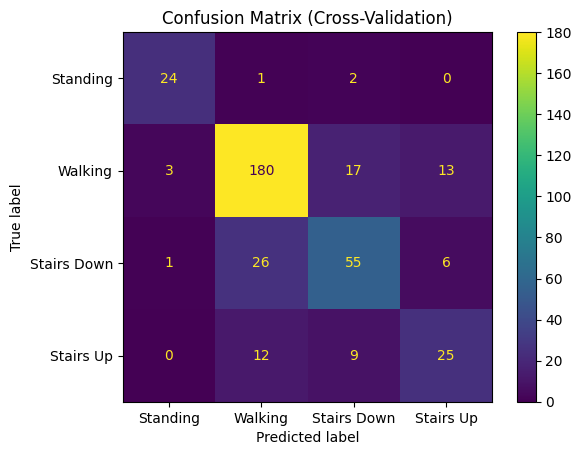

In [119]:
# Mapping for activity labels
activity_labels = ['Standing', 'Walking', 'Stairs Down', 'Stairs Up']

# Use cross-validated predictions on the training set with the best RandomForest model
Y_pred_cv = cross_val_predict(best_rf_model, X_train, Y_train, cv=cv)

# Compute the confusion matrix
cm = confusion_matrix(Y_train, Y_pred_cv)

# Display the confusion matrix with activity names
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels).plot()
plt.title("Confusion Matrix (Cross-Validation)")
plt.show()

Printing the ROC curve to visualize how the model compares to randm guessing.

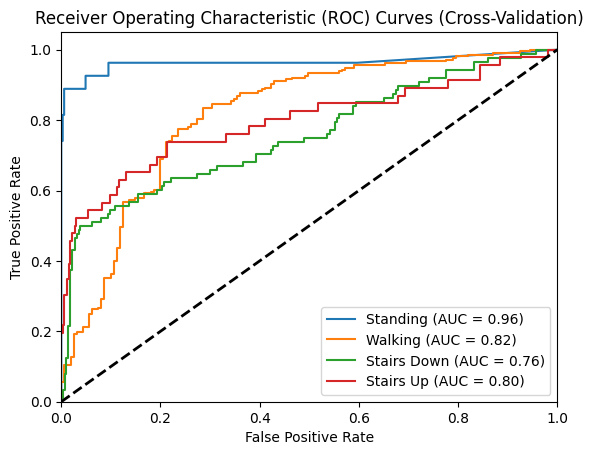

In [118]:
# Binarize the output for multiclass ROC curve
Y_train_bin = label_binarize(Y_train, classes=[1, 2, 3, 4])

# Fit OneVsRestClassifier with cross-validation predictions using RandomForest
ovr_classifier = OneVsRestClassifier(best_rf_model)
Y_pred_prob_cv = cross_val_predict(ovr_classifier, X_train, Y_train, cv=cv, method="predict_proba")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_train_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_train_bin[:, i], Y_pred_prob_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with activity names
plt.figure()
for i, label in enumerate(activity_labels):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

# Results

<h4>Model Performance</h4>

- **Cross-Validation**: The Random Forest model was evaluated using 5-fold cross-validation with stratified splits to manage class imbalance.
- **Best Model Parameters**: After hyperparameter tuning using GridSearchCV, the best model parameters for Random Forest were identified as:
  - `rf__bootstrap`: True
  - `rf__max_depth`: 5
  - `rf__min_samples_leaf`: 2
  - `rf__min_samples_split`: 5
  - `rf__n_estimators`: 75
- **Test Set Evaluation**:
  - The optimized Random Forest model was evaluated on the test set, achieving the following metrics:
    - `F1 Score`: 0.7535
    - `Precision`: 0.7565
    - `Recall`: 0.7594
    - `Accuracy`: 0.7594
- **Confusion Matrix and ROC curve**:
  - `Confusion Matrix`: Briefly, looking at the confusion matrix, it's clear that the model has some difficulty distinguishing between the stair movements, both from each other and from walking. However, it’s evident that it still attempts to classify all classes without a clear bias toward the most frequent class (Walking). The model struggles the most with the Stairs Up activity, which is understandable given its similarity to the other movement activities and its lower frequency in the dataset. Standing, while the least common class, is distinctly different from the others, which poses no problem for the model in correctly identifying it.
  - `ROC curve`: Briefly, all curves are well above the random guessing line, indicating that the model effectively distinguishes each activity class, including the minority ones. This suggests a balanced performance across classes, with better-than-naive recognition even in the presence of class imbalance.

In sum, despite having some difficulties distinguishing between some more similar classes, and not showing an outstanding performance, the model reflects a relatively fair judgment of all classes. The consistency of all the metrics, alongside with the confusion matrix and ROC curves, show a clear effort in making a distinction between activities without favoring most frequent classes to artificially increase accuracy.

<h4>Model Tuning and Performance Gain</h4>

- **Initial Model Selection**: Initially, multiple models were considered, including Random Forest, Decision Tree, K-Nearest Neighbors, Logistic Regression, and Support Vector Machine.
  - Random Forest was chosen due to its substancially better performance compared with the other models.
- **Hyperparameter Tuning**: Although hyperparameter tuning aimed to optimize the model, the performance gain from the initial selection to the final tuned model was lacking.
  - All parameters only improved slightly, indicating that the model was possibly at a limit, improvement wise.
  - To address this minimal gain, I would propose to continue an analysis in three fronts:
      - **Explainability of the Model**: Since RandomForest models can be hard to interpret, adding explainability techniques like `SHAP` or `feature importance plots` could provide more insight into which features are driving predictions. This could help refine the feature extraction process and provide deeper insights into the data.
      - **Feature Engineering Depth**: Adding more domain-specific features or further analysis of the frequency domain (such as identifying key frequency bands, energy-related features or making vertical acceleration an explicit feature) could improve the separability between similar activities, such as "walking" and "stairs down.".
      - **Imbalance Handling**: Advanced methods such as `adaptive resampling techniques` or `cost-sensitive learning`, which penalizes the model more for misclassifying minority classes, could be worth exploring.

---

## Storing prediction results

Adding the predicted activities to a new version of the `test_labels.csv` file.

In [188]:
# Display raw results.
Y_pred

array([2, 3, 4, 4, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4, 2, 4, 4, 4, 4, 3, 3, 4,
       2, 2, 4, 4, 4, 2, 4, 3, 4, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 3, 3, 3, 4, 4, 3, 4, 2, 1, 3, 3,
       3, 4, 3, 3, 2, 2, 3, 2, 3, 4, 3, 3, 3, 2, 2, 4, 2, 3, 3, 3, 2, 3,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [189]:
# Ensure Y_pred is the same length as test_labels
if len(Y_pred) != len(test_labels):
    raise ValueError("The length of Y_pred does not match the number of rows in test_labels.")
else:
    test_labels['label'] = Y_pred

# Save the updated DataFrame to a new CSV file
test_labels.to_csv('test_labels_updated.csv', index=False)

print("Updated test_labels.csv with predictions saved as 'test_labels_updated.csv'.")

Updated test_labels.csv with predictions saved as 'test_labels_updated.csv'.


## Performance Measurement

Ends the timer and displays the notebook's total running time.

In [190]:
# Stopping the timer and calculating total runtime
end_time = time.time()
runtime = end_time - start_time

In [191]:
# Displaying total runtime
print(f"Total runtime: {runtime} s")

Total runtime: 76.48149275779724 s


# Conclusions

This project aimed to develop a machine learning model for classifying accelerometer data into four activity categories: Standing, Walking, Stairs Down, and Stairs Up. After evaluating multiple models—including Random Forest, Decision Tree, K-Nearest Neighbors, Logistic Regression, and Support Vector Machine (SVM)—Random Forest was ultimately selected due to its superior F1 score and balanced performance across the activity classes, despite slight class imbalance.

### Summary of Findings

- **Model Performance**: The final Random Forest model, optimized through hyperparameter tuning, achieved a balanced F1 Score, Precision, and Recall, showing that the model performs fairly across all activity classes. This was further confirmed by the confusion matrix, which highlighted some difficulty distinguishing between similar activities, such as stairs up vs. stairs down, but minimal bias toward the more frequent activities.
  
- **Feature Extraction and Tuning**: Through feature extraction techniques, including Fourier Transform and statistical feature calculations, meaningful features were derived from the raw accelerometer data. Grid Search was used for hyperparameter tuning, yielding slight but consistent improvements in all key performance metrics. This suggests that while the current feature set and tuning strategy yield robust results, further optimization may be required for notable performance gains.

- **Class Imbalance Handling**: Incorporating SMOTE for oversampling the minority classes successfully mitigated class imbalance effects, enabling the model to achieve better recall for less frequent activities like standing and stairs up. This approach was beneficial but could be further improved with advanced imbalance handling methods to target the more challenging classes.

### Future Directions

1. **Explainability of the Model**: Adding interpretability techniques like SHAP values or feature importance analysis could offer insights into which features most significantly impact the predictions. This information could inform further improvements in feature engineering.
  
2. **Feature Engineering Depth**: To enhance model accuracy, additional domain-specific features could be considered. For example, focusing on key frequency bands, energy metrics, or vertical acceleration could help distinguish more nuanced activity differences.
  
3. **Advanced Imbalance Handling**: Methods such as adaptive resampling or cost-sensitive learning could improve the model's performance on minority classes, potentially addressing the misclassifications observed between similar activity classes.

### Conclusion

The Random Forest model demonstrated reliable performance across the four activity categories, capturing underlying patterns in accelerometer data and distinguishing activities with a fair degree of accuracy. The balanced metrics and model behavior suggest that the chosen approach is effective, though there is room for refinement, particularly in feature extraction and imbalance handling. Future work focusing on these areas could further enhance model performance, paving the way for a more precise and reliable activity classification tool.